# Needed libraries

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.vizier import Vizier
import sys
import scipy
from time import time
import healpy as hp
from itertools import product
from tqdm import tqdm
from scipy.stats import ks_2samp
from scipy.stats import binned_statistic_2d
import seaborn as sns

In [2]:
# Directory setup for custom modules
module_path = 'EagleEye/eagleeye'
sys.path.append(module_path)
import EagleEye_v7_UPSILONPARAM as EagleEye
#import EagleEye
import From_data_to_binary

# Custom Functions

In [3]:
##################################
####### EAGLEEYE FUNCTIONS #######
##################################
# Function to compute the Upsilon (𝛶) values from binary sequences
def compute_upsilon_values(binary_sequences, neighbor_range, num_cores):
    """Calculates the Upsilon values for anomaly detection using p-values across a range of neighbors."""
    # Create a PValueCalculatorParallel instance to access both pval_array_dict and smallest_pval_info
    p_value_calculator = EagleEye.PValueCalculatorParallel(binary_sequences, kstar_range=neighbor_range, num_cores=num_cores)
    
    # Calculate Upsilon values (𝛶) as the negative log of minimum p-values
    p_value_data = p_value_calculator.smallest_pval_info
    upsilon_values = -np.log(np.array(p_value_data['min_pval']))
    kstar_values = np.array(p_value_data['kstar_min_pval'])
    
    # Return both the calculator instance and the computed Upsilon values and k-star values
    return p_value_calculator, upsilon_values, kstar_values

# Function to retrieve Upsilon values for specific indices
def extract_upsilon_values(pval_info, indices, neighbor_range):
    """Extracts Upsilon values for given indices over a specified neighbor range."""
    return [[-np.log(pval_info.pval_array_dict[k][index, 0]) for k in neighbor_range] for index in indices]

# Function to find indices of interest based on Upsilon and k-star thresholds
def find_indices_by_threshold(upsilon_values, kstar_values, upsilon_thresh, kstar_thresh, condition='>'):
    """Finds indices where Upsilon and k-star values meet specified thresholds."""
    if condition == '>':
        indices = np.where((upsilon_values > upsilon_thresh) & (kstar_values < kstar_thresh))[0]
    else:
        indices = np.where((upsilon_values < upsilon_thresh) & (kstar_values > kstar_thresh))[0]
    return indices

In [4]:
# Function to plot the Upsilon sequences
def plot_nlpval(ax, nlpval1, nlpval2, nlpval3, label1, label2, label3,crit_v):
    ax.plot(range(4, len(nlpval1) + 4), nlpval1, color='limegreen', linewidth=2, label=label1)
    ax.plot(range(4, len(nlpval2) + 4), nlpval2, color='darkorange', linewidth=2, label=label2)
    ax.plot(range(4, len(nlpval3) + 4), nlpval3, color='magenta', linewidth=2, label=label2)
    # Apply logarithmic scale if necessary
    ax.set_yscale('log')
    # Highlight max values
    max_idx1 = np.argmax(nlpval1) + 4
    max_idx2 = np.argmax(nlpval2) + 4
    max_idx3 = np.argmax(nlpval3) + 4

    # ax.axvline(max_idx1, color='darkcyan', linestyle='--', linewidth=1.5, label=f'{label1} Kstar')
    # ax.axvline(max_idx2, color='red', linestyle='--', linewidth=1.5, label=f'{label2} Kstar')

    ax.axhline(y=crit_v, color='red', linestyle='--', linewidth=1.5, label='Crit. value')
    # ax.text(max_idx1, max(nlpval1), 'Kstar', color='darkcyan', verticalalignment='bottom', horizontalalignment='right', fontsize=17, fontweight='bold')
    # ax.text(max_idx2, max(nlpval2), 'Kstar', color='red', verticalalignment='bottom', horizontalalignment='right', fontsize=17, fontweight='bold')

    arrowprops_settings = dict(facecolor='darkcyan', edgecolor='darkcyan', shrink=0.05, width=2, headwidth=10, headlength=10)
    ax.annotate('', xy=(max_idx1, max(nlpval1)), xytext=(max_idx1, max(nlpval1) * 1.5),  # Slight adjustment for log scale
                arrowprops=arrowprops_settings)

    arrowprops_settings_red = dict(facecolor='chocolate', edgecolor='chocolate', shrink=0.05, width=2, headwidth=10, headlength=10)
    ax.annotate('', xy=(max_idx2, max(nlpval2)), xytext=(max_idx2, max(nlpval2) * 1.5),  # Slight adjustment for log scale
                arrowprops=arrowprops_settings_red)
    
    arrowprops_settings_mag = dict(facecolor='darkmagenta', edgecolor='darkmagenta', shrink=0.05, width=2, headwidth=10, headlength=10)
    ax.annotate('', xy=(max_idx3, max(nlpval3)), xytext=(max_idx3, max(nlpval3) * 1.5),  # Slight adjustment for log scale
                arrowprops=arrowprops_settings_mag)

    # Add 'Crit. value' text above the critical value line
    ax.text(395, crit_v * 1.1, 'Crit. line', color='red', fontsize=12, fontweight='bold',
            verticalalignment='bottom', horizontalalignment='right')


    ax.set_ylabel(r'$\Upsilon_i$', rotation=90)
    ax.set_xlim(0, 400-1)
    # ax.set_ylim(-5, max( [20, max(nlpval1), max(nlpval2)] )+10)
    ax.set_xlabel('K-nearest neighbors')
    # ax.legend(loc='upper right')

In [5]:
def LoadBkg(obs, glon_center, glat_center, eps_lon = 0, eps_lat = 0, row_limit = None, size = 2, reference = 'sim', ref_par = 2):
    
    gcenter = SkyCoord(frame="galactic", l = glon_center, b = glat_center, unit=(u.deg, u.deg))
    ra_center = gcenter.transform_to('icrs').ra.value
    dec_center = gcenter.transform_to('icrs').dec.value
    
    #%v = Vizier(columns=['RAICRS','DEICRS','pmRA','pmDE'],
    #%           column_filters={"Host":"1"}, row_limit = -1)
    
    v = Vizier(columns=['RAICRS','DEICRS','pmRA','pmDE'],
               column_filters={"Host":"1", 'Gmag':'<20', 'r':'>10000','logg':'>4'}, row_limit = -1)
    
    bkg = v.query_region(SkyCoord(ra = ra_center, dec=dec_center, unit=(u.deg, u.deg),frame='icrs'),
                            width= str(size) + "d",
                            catalog=["VI/137/gum_mw"])
    
    equatorial_coords = SkyCoord( ra  = bkg[0]['RAICRS'], 
                                  dec = bkg[0]['DEICRS'], 
                                  pm_ra_cosdec =  bkg[0]['pmRA'], 
                                  pm_dec = bkg[0]['pmDE'], 
                                  frame = 'icrs')
    
    # Transform to Galactic coordinates
    galactic_coords = equatorial_coords.transform_to('galactic')
    glon_full = galactic_coords.l.value
    glat_full = galactic_coords.b.value
    
    # Access proper motion in Galactic coordinates
    pmlon_full = galactic_coords.pm_l_cosb.to(u.mas/u.yr).value  # Proper motion in Galactic longitude (l)
    pmlat_full = galactic_coords.pm_b.to(u.mas/u.yr).value       # Proper motion in Galactic latitude (b)
    
    full = np.vstack((glon_full, glat_full, pmlon_full, pmlat_full)).T
        
    glon_dw = (obs[:,2] * 180/np.pi - 90) + glon_center + eps_lon # Just to center the dwarf galaxy
    glat_dw = (obs[:,3] * 180/np.pi - 30) + glat_center + eps_lat
    pmlon_dw = obs[:,5] / 1e3
    pmlat_dw = obs[:,6] / 1e3
    dw_data = np.vstack((glon_dw, glat_dw, pmlon_dw, pmlat_dw)).T

    if reference == 'sim':
        glon_ref = glon_center + 5
        glat_ref = glat_center
        gref = SkyCoord(frame="galactic", l = glon_ref, b = glat_ref, unit=(u.deg, u.deg))
        
        ra_ref = gref.transform_to('icrs').ra.value
        dec_ref = gref.transform_to('icrs').dec.value
        
        #v = Vizier(columns=['RAICRS','DEICRS','pmRA','pmDE'],
        #           column_filters={"Host":"1", 'Gmag':'<20', 'r':'>7500','logg':'>3.75'}, row_limit = -1)
                   #%column_filters={"Host":"1"}, row_limit = -1)
        
        ref = v.query_region(SkyCoord(ra = ra_ref, dec=dec_ref, unit=(u.deg, u.deg),frame='icrs'),
                                width= str(size + ref_par) + "d",
                                catalog=["VI/137/gum_mw"])
        
        equatorial_coords = SkyCoord( ra  = ref[0]['RAICRS'], 
                                      dec = ref[0]['DEICRS'], 
                                      pm_ra_cosdec =  ref[0]['pmRA'], 
                                      pm_dec = ref[0]['pmDE'], 
                                      frame = 'icrs')
        
        # Transform to Galactic coordinates
        galactic_coords = equatorial_coords.transform_to('galactic')
        glon_ref = galactic_coords.l.value - glon_ref + glon_center # To center around the same longitud
        glat_ref = galactic_coords.b.value
        
        # Access proper motion in Galactic coordinates
        pmlon_ref = galactic_coords.pm_l_cosb.to(u.mas/u.yr).value  # Proper motion in Galactic longitude (l)
        pmlat_ref = galactic_coords.pm_b.to(u.mas/u.yr).value       # Proper motion in Galactic latitude (b)
        
        ref = np.vstack((glon_ref, glat_ref, pmlon_ref, pmlat_ref)).T
        ind = np.where( (ref[:,0] >= np.min(full[:,0])) &
                        (ref[:,0] <= np.max(full[:,0])) &
                        (ref[:,1] >= np.min(full[:,1])) &
                        (ref[:,1] <= np.max(full[:,1])) &
                        (ref[:,2] >= np.min(full[:,2])) &
                        (ref[:,2] <= np.max(full[:,2])) &
                        (ref[:,3] >= np.min(full[:,3])) &
                        (ref[:,3] <= np.max(full[:,3])) 
                      )[0]
        ref = ref[ind]
    if reference == 'noisy':
        ref = np.copy(full)
        ref[:,0] = ref[:,0] + np.random.normal(0, np.std(dw_data[:,0]) / ref_par, len(ref[:,0]))
        ref[:,1] = ref[:,1] + np.random.normal(0, np.std(dw_data[:,1]) / ref_par, len(ref[:,1]))
        ref[:,2] = ref[:,2] + np.random.normal(0, np.std(dw_data[:,2]) / ref_par, len(ref[:,2]))
        ref[:,3] = ref[:,3] + np.random.normal(0, np.std(dw_data[:,3]) / ref_par, len(ref[:,3]))
        
    if row_limit is not None:
        np.random.shuffle(full)
        full = full[:row_limit]
        
        np.random.shuffle(ref)
        ref = ref[:row_limit]
        
    full = np.vstack((full, dw_data))

    return full, ref, dw_data

In [6]:
def purity(upsilon, ind, up_th = 20):
    '''
    Function to compute the purity of the cluster found by EE.

    Parameters
    ----------

    upsilon: (np.array) upsilon values of all the analized stars.
    ind: (np.array int) indices of the stars that trully belong to the dwarf galaxy.
    up_th: (float) upsilon threshold. default = 20

    Returns
    -------

    Purity defined as # dwarf stars (upsilon >= up_th) / # stars (upsilon >= up_th)
    '''
    return len(np.where(upsilon[ind] >= up_th)[0]) / len(np.where(upsilon >= up_th)[0])

def FPR(upsilon, ind, up_th = 20):
    '''
    Function to compute the false positive rate of the cluster found by EE.

    Parameters
    ----------

    upsilon: (np.array) upsilon values of all the analized stars.
    ind: (np.array int) indices of the stars that trully belong to the dwarf galaxy.
    up_th: (float) upsilon threshold. default = 20

    Returns
    -------

    False positive rate defined as # non-dwarf stars with upsilon >= up_th / # bkg stars
    '''
    ind_aux = np.arange(len(upsilon))
    ind_aux = np.delete(ind_aux, ind)
    return len(np.where(upsilon[ind_aux] >= up_th)[0]) / len(ind_aux)
    
def FNR(upsilon, ind, up_th = 20):
    '''
    Function to compute the dwarf stars missed by EE. (False Negative Rate)

    Parameters
    ----------

    upsilon: (np.array) upsilon values of all the analized stars.
    ind: (np.array int) indices of the stars that trully belong to the dwarf galaxy.
    up_th: (float) upsilon threshold. default = 20

    Returns
    -------

    FNR defined as # dwarf stars (upsilon < up_th) / # dwarf stars
    '''
    return len(np.where(upsilon[ind] < up_th)[0]) / len(ind)

def Delta(full, upsilon, ind, up_th = 20):
    '''
    Function to compute the distances (angular and peculiar velocity) between the center of the cluster found by EE
        and the dwarf galaxy.

    Parameters
    ----------

    full: (np.array) data of the analized stars.    
    upsilon: (np.array) upsilon values of all the analized stars.
    ind: (np.array int) indices of the stars that trully belong to the dwarf galaxy.
    up_th: (float) upsilon threshold. default = 20

    Returns
    -------

    Distances defined as 
        ang = np.sqrt( (l_{real} - <l>)^{2} + (b_{real} - <b>)^{2} )
        vpec = np.sqrt( (mul_{real} - <mul>)^{2} + (mub_{real} - <mub>)^{2} )
    '''
    l_real = np.mean(full[ind,0])
    b_real = np.mean(full[ind,1])
    mul_real = np.mean(full[ind,2])
    mub_real = np.mean(full[ind,3])

    ind_aux = np.where(upsilon >= up_th)[0]
    l_cluster = np.mean(full[ind_aux, 0])
    b_cluster = np.mean(full[ind_aux, 1])
    mul_cluster = np.mean(full[ind_aux, 2])
    mub_cluster = np.mean(full[ind_aux, 3])
    
    return np.sqrt( (l_real - l_cluster)**2 + (b_real - b_cluster)**2 ), \
           np.sqrt( (mul_real - mul_cluster)**2 + (mub_real - mub_cluster)**2 )

In [7]:
color_cl = 'red'
color_full = 'darkcyan'
color_dw = 'coral'
color_ref = 'black'

labels = ['$l$ [°]','$b$ [°]','$\mu_{l}$ [mas/yr]','$\mu_{b}$ [mas/yr]']



def plotDwarf(ax, dw_data, full = None, ref = None, indices = None, nbins = 20):
    bins = [np.linspace(np.mean(dw_data[:,0]) - 2, np.mean(dw_data[:,0]) + 2, nbins),
            np.linspace(np.mean(dw_data[:,1]) - 2, np.mean(dw_data[:,1]) + 2, nbins),
            np.linspace(np.mean(dw_data[:,2]) - 3, np.mean(dw_data[:,2]) + 3, nbins),
            np.linspace(np.mean(dw_data[:,3]) - 3, np.mean(dw_data[:,3]) + 3, nbins)]

    lims = [(np.mean(dw_data[:,0]) - 2, np.mean(dw_data[:,0]) + 2),
            (np.mean(dw_data[:,1]) - 2, np.mean(dw_data[:,1]) + 2),
            (np.mean(dw_data[:,2]) - 3, np.mean(dw_data[:,2]) + 3),
            (np.mean(dw_data[:,3]) - 3, np.mean(dw_data[:,3]) + 3)]

    if indices is not None: 
        cluster = full[indices,:] 
    else: 
        cluster = None
    
    for i in range(4):
        for j in range(4):
            if i < j: ax[i,j].set_axis_off()
            if i > j:
                #ax[i,j].set_xlim(lims[j])
                ax[i,j].set_ylim(lims[i])
                if cluster is not None: ax[i,j].scatter(cluster[:,j], cluster[:,i], edgecolor = color_cl, label = 'Cl', 
                                                        marker = 'o', s = 20, facecolor = 'none')
                if ref is not None: ax[i,j].scatter(ref[:,j], ref[:,i], color = color_ref, label = 'Ref', marker = '.', s = 5)
                if full is not None: ax[i,j].scatter(full[:,j], full[:,i], color = color_full, label = 'Bkg', marker = '.', s = 5)
                ax[i,j].scatter(dw_data[:,j], dw_data[:,i], color = color_dw, label = 'Dwarf', marker = '+')
            if i == j:
                if ref is not None: ax[i,j].hist(ref[:,i], histtype = 'step', density = True, bins = bins[i], color = color_ref)
                if full is not None: ax[i,j].hist(full[:,i], histtype = 'step', density = True, bins = bins[i], color = color_full)
                ax[i,j].hist(dw_data[:,i], histtype = 'step', density = True, bins = bins[i], color = color_dw)
                if cluster is not None: ax[i,j].hist(cluster[:,i], histtype = 'step', density = True, bins = bins[i], color = color_cl)
            if i == 3: 
                ax[i,j].set_xlabel(labels[j])
            #else:
             #   ax[i,j].set_xticks([])
            if j == 0: 
                ax[i,j].set_ylabel(labels[i])
            else: 
                ax[i,j].set_yticks([])
        
    ax[0,0].set_xlim(lims[0])
    ax[3,1].set_xlim(lims[1])
    ax[3,2].set_xlim(lims[2])
    ax[3,3].set_xlim(lims[3])
    
    ax[1,0].legend(loc = 'upper right', bbox_to_anchor = (2,2))
    return ax

# Let's start the analysis

In [8]:
# Let's load the true data for the galaxies
ifile = 96
data = np.loadtxt('../data/mocks/library.survey.UFGX_LIB' + str(ifile) + '.dat')

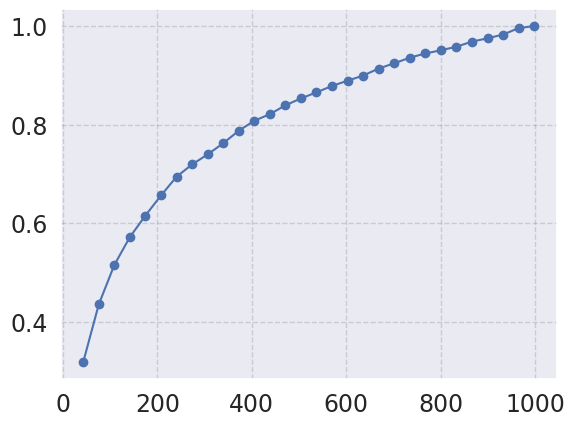

In [9]:
# Calcular el histograma
counts, bin_edges = np.histogram(data[:,12], bins=30, density=True)

# Calcular el histograma acumulado
cumulative_counts = np.cumsum(counts)  # Suma acumulativa

# Normalizar para que el acumulado llegue a 1
cumulative_counts /= cumulative_counts[-1]

# Graficar
plt.plot(bin_edges[1:], cumulative_counts, marker='o', linestyle='-')



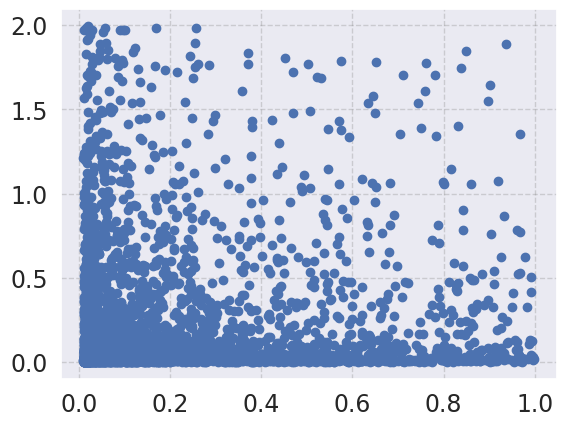

In [10]:
plt.scatter(data[:,13], data[:,14])

In [11]:
# Generate 100,000 Bernoulli sequences to determine the critical Upsilon threshold
num_sequences = 1000            # Number of Bernoulli sequences
K_M = 100                        # Length of each sequence
NUM_CORES = 100
NEIGHBOR_RANGE = range(4, K_M)
critical_quantile = 0.9999        # Quantile to calculate critical Upsilon threshold


validation  = None         # Number of samples to use for validation
kstar_range = range(20, K_M) # Range of kstar values to consider

In [12]:
nside = 1
NPIX = hp.nside2npix(nside)
glat, glon = np.degrees(hp.pix2ang(nside, np.arange(NPIX)))
glat = 90 - glat
len(np.where(np.abs(glat) > 20)[0])

8

In [240]:
glon

array([ 45., 135., 225., 315.,  45., 135., 225., 315.])

In [14]:
glon = glon[np.abs(glat) > 20]

In [15]:
glat = glat[np.abs(glat) > 20]

In [16]:
len(glon)

8

In [136]:
niter = 1#len(glat) #10 # Number of iterations per galaxy

Props = np.zeros(((len(data) * niter), 3)) # Let's initialize the properties array

Ids        = []
ang_sizes  = []
vpec_sizes = []
nstars     = []
pur        = []
falseNegR  = []
falsePosR  = []
dang       = []
dvpec      = []
bkg        = []
glats      = []
glons      = []

indices      = []
upsilons     = []
upsilons_na  = []
kstars       = []
kstars_na    = []
upsilons_val = []
kstars_val   = []

results = []
results_na = []

In [88]:
obs = np.loadtxt('../data/mocks/obs.lib96/UFGX_TEST96_lib/obs_960005.dat') # just to have something for the function to work
full_aux, ref, dw_data = LoadBkg(obs, glon_center = 90, glat_center = 30,
                             eps_lat = 0, eps_lon = 0, row_limit = None, size = 5)
bkg_data = full_aux[:-len(dw_data)]

In [89]:
ref.shape

(2392, 4)

In [90]:
bkg_data.shape

(2466, 4)

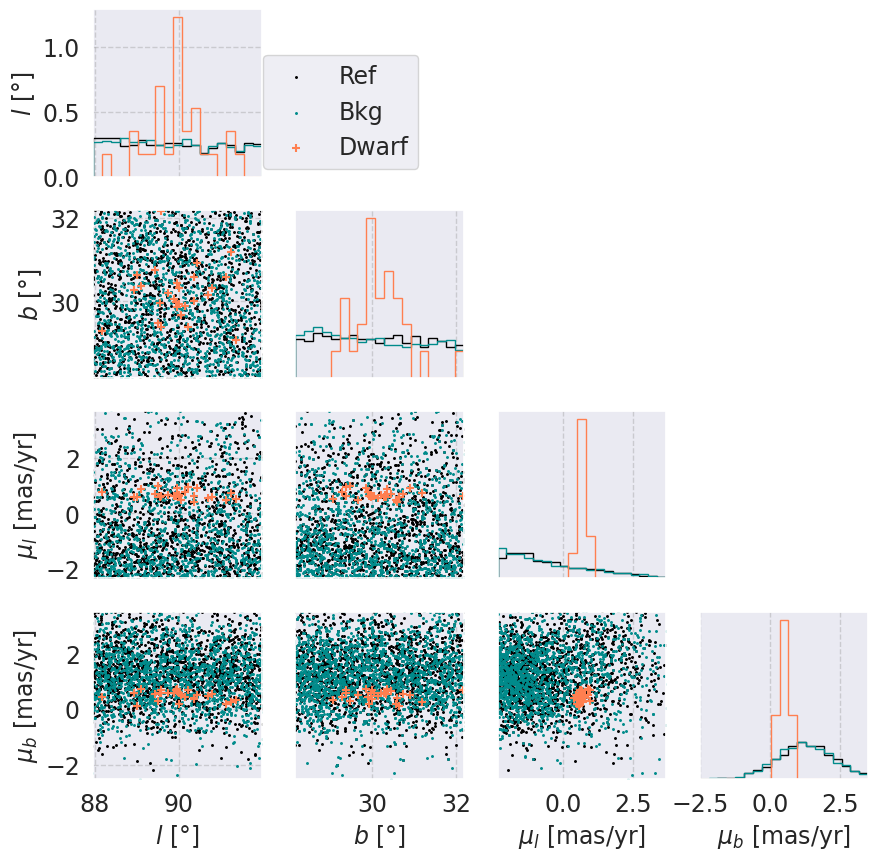

In [91]:
fig, ax  = plt.subplots(4,4, figsize = (10,10), sharex = 'col')

plt.subplots_adjust(hspace = 0.2, wspace = 0.2)

ax = plotDwarf(ax, dw_data, bkg_data, ref)

In [92]:
full.shape

(2493, 4)

In [93]:
ref.shape

(2392, 4)

In [94]:
result_dictionary_na = EagleEye.Soar(
    ref, bkg_data, result_dict_in = {}, K_M =100, critical_quantiles = None,
    num_cores=1, validation=None, partition_size=1, Upsilon_stars=[10])

Eagle...Soar!

                               /T /I
                              / |/ | .-~/
                          T\ Y  I  |/  /  _
         /T               | \I  |  I  Y.-~/
        I l   /I       T\ |  |  l  |  T  /
     T\ |  \ Y l  /T   | \I  l   \ `  l Y
 __  | \l   \l  \I l __l  l   \   `  _. |
 \ ~-l  `\   `\  \  \ ~\  \   `. .-~   |
  \   ~-. "-.  `  \  ^._ ^. "-.  /  \   |
.--~-._  ~-  `  _  ~-_.-"-." ._ /._ ." ./
 &gt;--.  ~-.   ._  ~&gt;-"    "\   7   7   ]
^.___~"--._    ~-{  .-~ .  `\ Y . /    |
 &lt;__ ~"-.  ~       /_/   \   \I  Y   : |
   ^-.__           ~(_/   \   &gt;._:   | l______
       ^--.,___.-~"  /_/   !  `-.~"--l_ /     ~"-.
              (_/ .  ~(   /'     "~"--,Y   -=b-. _)
               (_/ .  \  :           / l      c"~o \
                \ /    `.    .     .^   \_.-~"~--.  )
                 (_/ .   `  /     /       !       )/
                  / / _.   '.   .':      /        '
                  ~(_/ .   /    _  `  .-&lt;_
                    /_/ 

In [ ]:
start0 = time()

counter = 0
for igal in tqdm(range(0, len(data))):
    start = time()
    for iiter in range(niter):
        if data[igal,12] < 40000:
            
            Ids.append(int(data[igal,0]))
            
            obs = np.loadtxt('../data/mocks/obs.lib' + str(ifile) + '/UFGX_TEST' + str(ifile) + '_lib/obs_' + str(int(Ids[counter])) + '.dat')
            print(len(obs))

            if niter > 1:
                full, ref, dw_data = LoadBkg(obs, glon_center = glon[iiter], glat_center = glat[iiter],
                                             eps_lat = 0, eps_lon = 0, row_limit = None, size = 3)
            else:
                glon_dw = (obs[:,2] * 180/np.pi - 90) + 90 # Just to center the dwarf galaxy
                glat_dw = (obs[:,3] * 180/np.pi - 30) + 30
                pmlon_dw = obs[:,5] / 1e3
                pmlat_dw = obs[:,6] / 1e3
                dw_data = np.vstack((glon_dw, glat_dw, pmlon_dw, pmlat_dw)).T
                full = np.vstack((bkg_data, dw_data))

            nstars.append( len(obs) )
            ang_sizes.append( data[igal,13] )
            vpec_sizes.append( data[igal,14] )
            bkg.append((len(full) - len(dw_data)))
            glons.append(glon[iiter])
            glats.append(glat[iiter])
            
            ind = np.arange(len(full))[-len(dw_data):]
    
            # Begin calls to EagleEye (version 7)
            try:
                result_dictionary = EagleEye.Soar(
                    ref, full, result_dict_in = {}, K_M = K_M, critical_quantiles = None,
                    num_cores=NUM_CORES, validation=int(np.min((len(full), len(ref)))), partition_size=100,Upsilon_stars=[10] )
            except:
                result_dictionary = EagleEye.Soar(
                    ref, full, result_dict_in = {}, K_M = K_M, critical_quantiles = None,
                    num_cores=NUM_CORES, validation=int(np.min((len(full), len(ref)))), partition_size=100,Upsilon_stars=None)

            
            result_dictionary[i]['Ids'] = int(data[igal,0])
            result_dictionary[i]['ang_sizes'] = data[igal,13]
            result_dictionary[i]['vpec_sizes'] = data[igal,14]
            result_dictionary[i]['nstars'] = len(obs)
            result_dictionary[i]['bkg'] = (len(full) - len(dw_data))
            result_dictionary[i]['glat'] = glat[iiter]
            result_dictionary[i]['glon'] = glon[iiter]
            
            results.append(result_dictionary)
    
            #&result_dictionary_na = EagleEye.Soar(
            #&    ref, full[:-len(dw_data)], result_dict_in = {}, K_M = K_M, critical_quantiles = None,
            #&    num_cores=NUM_CORES, validation=None, partition_size=100, Upsilon_stars=[10] )
            #results_na.append(result_dictionary_na)
            # ---------------------------------------------------------------------------------
    
            # Begin calls to EagleEye (new version)
            #%binary_sequences = From_data_to_binary.create_binary_array_cdist(full, ref, num_neighbors = K_M, 
            #%                                                                 num_cores = NUM_CORES, validation = validation, partition_size = 10)
            #%stats = EagleEye.calculate_p_values(binary_sequences, kstar_range = kstar_range, validation = validation, num_cores = NUM_CORES)
            #%upsilon, kstar, upsilon_val, kstar_val = stats['Upsilon_i'],stats['kstar_'],stats['Upsilon_i_Val'],stats['kstar_Val']
            #%
            #%binary_sequences_na = From_data_to_binary.create_binary_array_cdist(full[:-len(dw_data)], ref, num_neighbors = K_M, 
            #%                                                                 num_cores = NUM_CORES, validation = validation, partition_size = 10)
            #%stats_na = EagleEye.calculate_p_values(binary_sequences_na, kstar_range = kstar_range, validation = validation, num_cores = NUM_CORES)
            #%upsilon_na, kstar_na, upsilon_val_na, kstar_val_na = stats_na['Upsilon_i'],stats_na['kstar_'],stats_na['Upsilon_i_Val'],stats_na['kstar_Val']
            
            #%upsilons.append(upsilon)
            #%upsilons_na.append(upsilon_na)
            #%kstars.append(kstar)
            #%kstars_na.append(kstar_na)
            #%upsilons_val.append(upsilon_val)
            #%kstars_val.append(kstar_val)
            #%up_th = np.quantile(upsilon, 0.8)
            #%indices.append(np.where(upsilon >= up_th)[0])
            #%pur.append(purity(upsilon, ind, up_th = up_th))
            #%falseNegR.append(FNR(upsilon, ind, up_th = up_th))
            #%falsePosR.append(FPR(upsilon, ind, up_th = up_th))
            #%aux1, aux2 = Delta(full, upsilon, ind, up_th = up_th)
            #%dang.append(aux1)
            #%dvpec.append(aux2)
            # ---------------------------------------------------------------------------------
            
            counter = counter + 1
        stop = time()
        print('It takes {:.2f} hs to analyze a dwarf with {} stars at {} positions'.format((stop-start)/3600, len(dw_data), niter))

#Ids        = np.asarray(Ids)
#ang_sizes  = np.asarray(ang_sizes)
#vpec_sizes = np.asarray(vpec_sizes)
#nstars     = np.asarray(nstars)
#bkg        = np.asarray(bkg)
#glats      = np.asarray(glats)
#glons      = np.asarray(glons)

#%pur        = np.asarray(pur)
#%falseNegR  = np.asarray(falseNegR)
#%falsePosR  = np.asarray(falsePosR)
#%dang       = np.asarray(dang)
#%dvpec      = np.asarray(dvpec)

  0%|          | 0/3000 [00:00<?, ?it/s]

371
Eagle...Soar!

                               /T /I
                              / |/ | .-~/
                          T\ Y  I  |/  /  _
         /T               | \I  |  I  Y.-~/
        I l   /I       T\ |  |  l  |  T  /
     T\ |  \ Y l  /T   | \I  l   \ `  l Y
 __  | \l   \l  \I l __l  l   \   `  _. |
 \ ~-l  `\   `\  \  \ ~\  \   `. .-~   |
  \   ~-. "-.  `  \  ^._ ^. "-.  /  \   |
.--~-._  ~-  `  _  ~-_.-"-." ._ /._ ." ./
 &gt;--.  ~-.   ._  ~&gt;-"    "\   7   7   ]
^.___~"--._    ~-{  .-~ .  `\ Y . /    |
 &lt;__ ~"-.  ~       /_/   \   \I  Y   : |
   ^-.__           ~(_/   \   &gt;._:   | l______
       ^--.,___.-~"  /_/   !  `-.~"--l_ /     ~"-.
              (_/ .  ~(   /'     "~"--,Y   -=b-. _)
               (_/ .  \  :           / l      c"~o \
                \ /    `.    .     .^   \_.-~"~--.  )
                 (_/ .   `  /     /       !       )/
                  / / _.   '.   .':      /        '
                  ~(_/ .   /    _  `  .-&lt;_
                    

  0%|          | 1/3000 [00:05<4:41:08,  5.62s/it]

Max Upsilon remaining: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2837,)        
  kstar_minus                  (2837,)        
  Upsilon_i_plus               (2837,)        
  kstar_plus                   (2837,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (2392,)        
  Upsilon_i_Val_minus          (2392,)        
  ks

  0%|          | 2/3000 [00:14<6:20:35,  7.62s/it]


Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
stats                          dict           
  Upsilon_i_minus              (3461,)        
  kstar_minus                  (3461,)        
  Upsilon_i_plus               (3461,)        
  kstar_plus                   (3461,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (

  0%|          | 3/3000 [00:20<5:51:49,  7.04s/it]

Max Upsilon remaining: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2612,)        
  kstar_minus                  (2612,)        
  Upsilon_i_plus               (2612,)        
  kstar_plus                   (2612,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (2392,)        
  Upsilon_i_Val_minus          (2392,)        
  ks

  0%|          | 4/3000 [00:27<5:48:49,  6.99s/it]

Max Upsilon remaining: 10.449427720346801
Max Upsilon remained: 11.534371971844822
Max Upsilon remained: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2506,)        
  kstar_minus                  (2506,)        
  Upsilon_i_plus               (2506,)        
  kstar_plus                   (2506,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus    

  0%|          | 5/3000 [00:34<5:48:55,  6.99s/it]

Max Upsilon remaining: 10.50829339000259
Max Upsilon remained: 11.472036128619413
Max Upsilon remained: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2493,)        
  kstar_minus                  (2493,)        
  Upsilon_i_plus               (2493,)        
  kstar_plus                   (2493,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus     

  0%|          | 6/3000 [00:41<5:50:34,  7.03s/it]

Max Upsilon remaining: 10.240798193469622
Max Upsilon remained: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2553,)        
  kstar_minus                  (2553,)        
  Upsilon_i_plus               (2553,)        
  kstar_plus                   (2553,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (2392,)        
  Upsilon_

  0%|          | 7/3000 [00:48<5:48:29,  6.99s/it]

Max Upsilon remaining: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2629,)        
  kstar_minus                  (2629,)        
  Upsilon_i_plus               (2629,)        
  kstar_plus                   (2629,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (2392,)        
  Upsilon_i_Val_minus          (2392,)        
  ks

  0%|          | 8/3000 [00:55<5:48:42,  6.99s/it]

Max Upsilon remaining: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2817,)        
  kstar_minus                  (2817,)        
  Upsilon_i_plus               (2817,)        
  kstar_plus                   (2817,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (2392,)        
  Upsilon_i_Val_minus          (2392,)        
  ks

  0%|          | 9/3000 [01:04<6:11:49,  7.46s/it]

Max Upsilon remaining: 10.576854949035505
Max Upsilon remained: 11.39996244654641
Max Upsilon remained: 10.8217580295303
Max Upsilon remained: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2478,)        
  kstar_minus                  (2478,)        
  Upsilon_i_plus               (2478,)        
  kstar_plus                   (2478,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus         

  0%|          | 10/3000 [01:12<6:15:46,  7.54s/it]

Max Upsilon remaining: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2736,)        
  kstar_minus                  (2736,)        
  Upsilon_i_plus               (2736,)        
  kstar_plus                   (2736,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (2392,)        
  Upsilon_i_Val_minus          (2392,)        
  ks

  0%|          | 11/3000 [01:22<6:57:53,  8.39s/it]

Max Upsilon remaining: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2779,)        
  kstar_minus                  (2779,)        
  Upsilon_i_plus               (2779,)        
  kstar_plus                   (2779,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (2392,)        
  Upsilon_i_Val_minus          (2392,)        
  ks

  0%|          | 12/3000 [01:30<6:49:26,  8.22s/it]

Max Upsilon remaining: 10.586048775215678
Max Upsilon remained: 11.390340652364394
Max Upsilon remained: 10.812542431487675
Max Upsilon remained: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2476,)        
  kstar_minus                  (2476,)        
  Upsilon_i_plus               (2476,)        
  kstar_plus                   (2476,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus      

  0%|          | 13/3000 [01:36<6:18:40,  7.61s/it]

Max Upsilon remaining: 10.572262670312817
Max Upsilon remained: 11.40477228696407
Max Upsilon remained: 10.826364832253978
Max Upsilon remained: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2479,)        
  kstar_minus                  (2479,)        
  Upsilon_i_plus               (2479,)        
  kstar_plus                   (2479,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus       

  0%|          | 14/3000 [01:45<6:35:16,  7.94s/it]


Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
stats                          dict           
  Upsilon_i_minus              (3082,)        
  kstar_minus                  (3082,)        
  Upsilon_i_plus               (3082,)        
  kstar_plus                   (3082,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (

  0%|          | 15/3000 [01:51<6:04:39,  7.33s/it]

Max Upsilon remaining: 10.417941634395826
Max Upsilon remained: 11.567888251063254
Max Upsilon remained: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2513,)        
  kstar_minus                  (2513,)        
  Upsilon_i_plus               (2513,)        
  kstar_plus                   (2513,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus    

  1%|          | 16/3000 [01:59<6:14:02,  7.52s/it]

Max Upsilon remaining: 10.581450316331809
Max Upsilon remained: 11.395151901703636
Max Upsilon remained: 10.817150562627013
Max Upsilon remained: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2477,)        
  kstar_minus                  (2477,)        
  Upsilon_i_plus               (2477,)        
  kstar_plus                   (2477,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus      

  1%|          | 17/3000 [02:05<5:59:25,  7.23s/it]

Max Upsilon remaining: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2677,)        
  kstar_minus                  (2677,)        
  Upsilon_i_plus               (2677,)        
  kstar_plus                   (2677,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (2392,)        
  Upsilon_i_Val_minus          (2392,)        
  ks

  1%|          | 18/3000 [02:14<6:30:46,  7.86s/it]


Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
stats                          dict           
  Upsilon_i_minus              (3205,)        
  kstar_minus                  (3205,)        
  Upsilon_i_plus               (3205,)        
  kstar_plus                   (3205,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (

  1%|          | 19/3000 [02:21<6:05:18,  7.35s/it]

Max Upsilon remaining: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2681,)        
  kstar_minus                  (2681,)        
  Upsilon_i_plus               (2681,)        
  kstar_plus                   (2681,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (2392,)        
  Upsilon_i_Val_minus          (2392,)        
  ks

  1%|          | 20/3000 [02:27<5:49:49,  7.04s/it]

Max Upsilon remaining: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2778,)        
  kstar_minus                  (2778,)        
  Upsilon_i_plus               (2778,)        
  kstar_plus                   (2778,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (2392,)        
  Upsilon_i_Val_minus          (2392,)        
  ks

  1%|          | 21/3000 [02:33<5:39:20,  6.83s/it]

Max Upsilon remaining: 10.04699946326124
Max Upsilon remained: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2598,)        
  kstar_minus                  (2598,)        
  Upsilon_i_plus               (2598,)        
  kstar_plus                   (2598,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (2392,)        
  Upsilon_i

  1%|          | 22/3000 [02:40<5:34:52,  6.75s/it]

Max Upsilon remaining: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2844,)        
  kstar_minus                  (2844,)        
  Upsilon_i_plus               (2844,)        
  kstar_plus                   (2844,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (2392,)        
  Upsilon_i_Val_minus          (2392,)        
  ks

  1%|          | 23/3000 [02:46<5:31:06,  6.67s/it]

Max Upsilon remaining: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2625,)        
  kstar_minus                  (2625,)        
  Upsilon_i_plus               (2625,)        
  kstar_plus                   (2625,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (2392,)        
  Upsilon_i_Val_minus          (2392,)        
  ks

  1%|          | 24/3000 [02:53<5:37:50,  6.81s/it]

Max Upsilon remaining: 10.382136611867283
Max Upsilon remained: 11.606150463686506
Max Upsilon remained: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2521,)        
  kstar_minus                  (2521,)        
  Upsilon_i_plus               (2521,)        
  kstar_plus                   (2521,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus    

  1%|          | 25/3000 [03:00<5:28:29,  6.63s/it]

Max Upsilon remaining: 10.467485832746773
Max Upsilon remained: 11.515204362397464
Max Upsilon remained: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2502,)        
  kstar_minus                  (2502,)        
  Upsilon_i_plus               (2502,)        
  kstar_plus                   (2502,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus    

  1%|          | 26/3000 [03:06<5:22:40,  6.51s/it]

Max Upsilon remaining: 10.236429249325651
Max Upsilon remained: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2554,)        
  kstar_minus                  (2554,)        
  Upsilon_i_plus               (2554,)        
  kstar_plus                   (2554,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (2392,)        
  Upsilon_

  1%|          | 27/3000 [03:12<5:18:16,  6.42s/it]

Max Upsilon remaining: 10.119543998993201
Max Upsilon remained: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2581,)        
  kstar_minus                  (2581,)        
  Upsilon_i_plus               (2581,)        
  kstar_plus                   (2581,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (2392,)        
  Upsilon_

  1%|          | 28/3000 [03:18<5:15:14,  6.36s/it]

Max Upsilon remaining: 10.422430666994874
Max Upsilon remained: 11.56310231720417
Max Upsilon remained: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2512,)        
  kstar_minus                  (2512,)        
  Upsilon_i_plus               (2512,)        
  kstar_plus                   (2512,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus     

  1%|          | 29/3000 [03:25<5:15:17,  6.37s/it]

Max Upsilon remaining: 10.476532981771555
Max Upsilon remained: 11.505616342067635
Max Upsilon remained: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2500,)        
  kstar_minus                  (2500,)        
  Upsilon_i_plus               (2500,)        
  kstar_plus                   (2500,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus    

  1%|          | 30/3000 [03:32<5:30:21,  6.67s/it]

Max Upsilon remaining: 10.526509094389636
Max Upsilon remained: 11.452831963603801
Max Upsilon remained: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2489,)        
  kstar_minus                  (2489,)        
  Upsilon_i_plus               (2489,)        
  kstar_plus                   (2489,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus    

  1%|          | 31/3000 [03:39<5:33:31,  6.74s/it]

Max Upsilon remaining: 10.449427720346801
Max Upsilon remained: 11.534371971844822
Max Upsilon remained: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2506,)        
  kstar_minus                  (2506,)        
  Upsilon_i_plus               (2506,)        
  kstar_plus                   (2506,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus    

  1%|          | 32/3000 [03:45<5:25:31,  6.58s/it]

Max Upsilon remaining: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2795,)        
  kstar_minus                  (2795,)        
  Upsilon_i_plus               (2795,)        
  kstar_plus                   (2795,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (2392,)        
  Upsilon_i_Val_minus          (2392,)        
  ks

  1%|          | 33/3000 [03:51<5:19:14,  6.46s/it]

Max Upsilon remaining: 10.458450753378214
Max Upsilon remained: 11.524789572119348
Max Upsilon remained: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2504,)        
  kstar_minus                  (2504,)        
  Upsilon_i_plus               (2504,)        
  kstar_plus                   (2504,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus    

  1%|          | 34/3000 [04:01<6:02:28,  7.33s/it]


Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
stats                          dict           
  Upsilon_i_minus              (3103,)        
  kstar_minus                  (3103,)        
  Upsilon_i_plus               (3103,)        
  kstar_plus                   (3103,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (

  1%|          | 35/3000 [04:07<5:45:26,  6.99s/it]

Max Upsilon remaining: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2830,)        
  kstar_minus                  (2830,)        
  Upsilon_i_plus               (2830,)        
  kstar_plus                   (2830,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (2392,)        
  Upsilon_i_Val_minus          (2392,)        
  ks

  1%|          | 36/3000 [04:13<5:38:19,  6.85s/it]

Max Upsilon remaining: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2891,)        
  kstar_minus                  (2891,)        
  Upsilon_i_plus               (2891,)        
  kstar_plus                   (2891,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (2392,)        
  Upsilon_i_Val_minus          (2392,)        
  ks

  1%|          | 37/3000 [04:20<5:30:35,  6.69s/it]

Max Upsilon remaining: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2664,)        
  kstar_minus                  (2664,)        
  Upsilon_i_plus               (2664,)        
  kstar_plus                   (2664,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (2392,)        
  Upsilon_i_Val_minus          (2392,)        
  ks

  1%|▏         | 38/3000 [04:27<5:34:57,  6.79s/it]

Max Upsilon remaining: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2729,)        
  kstar_minus                  (2729,)        
  Upsilon_i_plus               (2729,)        
  kstar_plus                   (2729,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (2392,)        
  Upsilon_i_Val_minus          (2392,)        
  ks

  1%|▏         | 39/3000 [04:40<7:04:23,  8.60s/it]


Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
stats                          dict           
  Upsilon_i_minus              (3423,)        
  kstar_minus                  (3423,)        
  Upsilon_i_plus               (3423,)        
  kstar_plus                   (3423,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (

  1%|▏         | 40/3000 [04:47<6:47:34,  8.26s/it]

Max Upsilon remaining: 10.544773689739415
Max Upsilon remained: 11.43361654056432
Max Upsilon remained: 10.853991704011637
Max Upsilon remained: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2485,)        
  kstar_minus                  (2485,)        
  Upsilon_i_plus               (2485,)        
  kstar_plus                   (2485,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus       

  1%|▏         | 41/3000 [04:54<6:34:30,  8.00s/it]

Max Upsilon remaining: 10.535635268811351
Max Upsilon remained: 11.443225659631409
Max Upsilon remained: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2487,)        
  kstar_minus                  (2487,)        
  Upsilon_i_plus               (2487,)        
  kstar_plus                   (2487,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus    

  1%|▏         | 42/3000 [05:02<6:25:05,  7.81s/it]

Max Upsilon remaining: 10.567673477153738
Max Upsilon remained: 11.409581423028174
Max Upsilon remained: 10.830970970854695
Max Upsilon remained: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2480,)        
  kstar_minus                  (2480,)        
  Upsilon_i_plus               (2480,)        
  kstar_plus                   (2480,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus      

  1%|▏         | 43/3000 [05:09<6:16:26,  7.64s/it]

Max Upsilon remaining: 10.526509094389636
Max Upsilon remained: 11.452831963603801
Max Upsilon remained: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2489,)        
  kstar_minus                  (2489,)        
  Upsilon_i_plus               (2489,)        
  kstar_plus                   (2489,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus    

  1%|▏         | 44/3000 [05:17<6:20:03,  7.71s/it]

Max Upsilon remaining: 10.576854949035505
Max Upsilon remained: 11.39996244654641
Max Upsilon remained: 10.8217580295303
Max Upsilon remained: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2478,)        
  kstar_minus                  (2478,)        
  Upsilon_i_plus               (2478,)        
  kstar_plus                   (2478,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus         

  2%|▏         | 45/3000 [05:23<6:00:43,  7.32s/it]

Max Upsilon remaining: 10.485592223832587
Max Upsilon remained: 11.496025510521418
Max Upsilon remained: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2498,)        
  kstar_minus                  (2498,)        
  Upsilon_i_plus               (2498,)        
  kstar_plus                   (2498,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus    

In [243]:
start0 = time()
glon = [90]
glat = [30]

counter = 0
results = []
for iiter in range(1):
    obs = np.loadtxt('../data/mocks/obs.lib96/UFGX_TEST96_lib/obs_960005.dat') # just to have something for the function to work
    full_aux, ref, dw_data = LoadBkg(obs, glon_center = 90, glat_center = 30,
                                 eps_lat = 0, eps_lon = 0, row_limit = None, size = 5)
    bkg_data = full_aux[:-len(dw_data)]
    
    try:
        result_dictionary_na = EagleEye.Soar(
                            ref, bkg_data, result_dict_in = {}, K_M =100, critical_quantiles = None,
                            num_cores=1, validation=None, partition_size=1, Upsilon_stars=[10])
    except:
        result_dictionary_na = EagleEye.Soar(
                            ref, bkg_data, result_dict_in = {}, K_M =100, critical_quantiles = None,
                            num_cores=1, validation=None, partition_size=1, Upsilon_stars=None)
    start = time()
    for igal in tqdm(range(0, 10)):
        if data[igal,12] < 40000:
            
            obs = np.loadtxt('../data/mocks/obs.lib' + str(ifile) + '/UFGX_TEST' + str(ifile) + '_lib/obs_' + str(int(data[igal,0])) + '.dat')
            print(len(obs))

            glon_dw = (obs[:,2] * 180/np.pi - 90) + glon[iiter] # Just to center the dwarf galaxy
            glat_dw = (obs[:,3] * 180/np.pi - 30) + glat[iiter]
            pmlon_dw = obs[:,5] / 1e3
            pmlat_dw = obs[:,6] / 1e3
            dw_data = np.vstack((glon_dw, glat_dw, pmlon_dw, pmlat_dw)).T
            full = np.vstack((bkg_data, dw_data))
    
            # Begin calls to EagleEye (version 7)
            try:
                result_dictionary = EagleEye.Soar(
                    ref, full, result_dict_in = {}, K_M = K_M, critical_quantiles = None,
                    num_cores=NUM_CORES, validation=int(np.min((len(full), len(ref)))), partition_size=100,Upsilon_stars=[10] )
            except:
                result_dictionary = EagleEye.Soar(
                    ref, full, result_dict_in = {}, K_M = K_M, critical_quantiles = None,
                    num_cores=NUM_CORES, validation=int(np.min((len(full), len(ref)))), partition_size=100,Upsilon_stars=None)

            
            result_dictionary['Ids'] = int(data[igal,0])
            result_dictionary['ang_sizes'] = data[igal,13]
            result_dictionary['vpec_sizes'] = data[igal,14]
            result_dictionary['nstars'] = len(obs)
            result_dictionary['bkg'] = (len(full) - len(dw_data))
            result_dictionary['glat'] = glat[iiter]
            result_dictionary['glon'] = glon[iiter]
            
            results.append(result_dictionary)
            
            counter = counter + 1
        stop = time()
        print('It takes {:.2f} hs to analyze a dwarf with {} stars at {} positions'.format((stop-start)/3600, len(dw_data), niter))

Eagle...Soar!

                               /T /I
                              / |/ | .-~/
                          T\ Y  I  |/  /  _
         /T               | \I  |  I  Y.-~/
        I l   /I       T\ |  |  l  |  T  /
     T\ |  \ Y l  /T   | \I  l   \ `  l Y
 __  | \l   \l  \I l __l  l   \   `  _. |
 \ ~-l  `\   `\  \  \ ~\  \   `. .-~   |
  \   ~-. "-.  `  \  ^._ ^. "-.  /  \   |
.--~-._  ~-  `  _  ~-_.-"-." ._ /._ ." ./
 &gt;--.  ~-.   ._  ~&gt;-"    "\   7   7   ]
^.___~"--._    ~-{  .-~ .  `\ Y . /    |
 &lt;__ ~"-.  ~       /_/   \   \I  Y   : |
   ^-.__           ~(_/   \   &gt;._:   | l______
       ^--.,___.-~"  /_/   !  `-.~"--l_ /     ~"-.
              (_/ .  ~(   /'     "~"--,Y   -=b-. _)
               (_/ .  \  :           / l      c"~o \
                \ /    `.    .     .^   \_.-~"~--.  )
                 (_/ .   `  /     /       !       )/
                  / / _.   '.   .':      /        '
                  ~(_/ .   /    _  `  .-&lt;_
                    /_/ 

  0%|          | 0/10 [00:00<?, ?it/s]

371
Eagle...Soar!

                               /T /I
                              / |/ | .-~/
                          T\ Y  I  |/  /  _
         /T               | \I  |  I  Y.-~/
        I l   /I       T\ |  |  l  |  T  /
     T\ |  \ Y l  /T   | \I  l   \ `  l Y
 __  | \l   \l  \I l __l  l   \   `  _. |
 \ ~-l  `\   `\  \  \ ~\  \   `. .-~   |
  \   ~-. "-.  `  \  ^._ ^. "-.  /  \   |
.--~-._  ~-  `  _  ~-_.-"-." ._ /._ ." ./
 &gt;--.  ~-.   ._  ~&gt;-"    "\   7   7   ]
^.___~"--._    ~-{  .-~ .  `\ Y . /    |
 &lt;__ ~"-.  ~       /_/   \   \I  Y   : |
   ^-.__           ~(_/   \   &gt;._:   | l______
       ^--.,___.-~"  /_/   !  `-.~"--l_ /     ~"-.
              (_/ .  ~(   /'     "~"--,Y   -=b-. _)
               (_/ .  \  :           / l      c"~o \
                \ /    `.    .     .^   \_.-~"~--.  )
                 (_/ .   `  /     /       !       )/
                  / / _.   '.   .':      /        '
                  ~(_/ .   /    _  `  .-&lt;_
                    

 10%|█         | 1/10 [00:25<03:53, 25.98s/it]

Max Upsilon remaining: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2837,)        
  kstar_minus                  (2837,)        
  Upsilon_i_plus               (2837,)        
  kstar_plus                   (2837,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (2392,)        
  Upsilon_i_Val_minus          (2392,)        
  ks

 20%|██        | 2/10 [01:03<04:20, 32.58s/it]


Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
stats                          dict           
  Upsilon_i_minus              (3461,)        
  kstar_minus                  (3461,)        
  Upsilon_i_plus               (3461,)        
  kstar_plus                   (3461,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (

 30%|███       | 3/10 [01:29<03:28, 29.76s/it]

Max Upsilon remaining: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2612,)        
  kstar_minus                  (2612,)        
  Upsilon_i_plus               (2612,)        
  kstar_plus                   (2612,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (2392,)        
  Upsilon_i_Val_minus          (2392,)        
  ks

 40%|████      | 4/10 [01:55<02:48, 28.07s/it]

Max Upsilon remaining: 10.449427720346801
Max Upsilon remained: 11.534371971844822
Max Upsilon remained: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2506,)        
  kstar_minus                  (2506,)        
  Upsilon_i_plus               (2506,)        
  kstar_plus                   (2506,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus    

 50%|█████     | 5/10 [02:21<02:17, 27.54s/it]

Max Upsilon remaining: 10.50829339000259
Max Upsilon remained: 11.472036128619413
Max Upsilon remained: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2493,)        
  kstar_minus                  (2493,)        
  Upsilon_i_plus               (2493,)        
  kstar_plus                   (2493,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus     

 60%|██████    | 6/10 [02:49<01:49, 27.48s/it]

Max Upsilon remaining: 10.240798193469622
Max Upsilon remained: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2553,)        
  kstar_minus                  (2553,)        
  Upsilon_i_plus               (2553,)        
  kstar_plus                   (2553,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (2392,)        
  Upsilon_

 70%|███████   | 7/10 [03:14<01:20, 26.90s/it]

Max Upsilon remaining: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2629,)        
  kstar_minus                  (2629,)        
  Upsilon_i_plus               (2629,)        
  kstar_plus                   (2629,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (2392,)        
  Upsilon_i_Val_minus          (2392,)        
  ks

 80%|████████  | 8/10 [03:40<00:53, 26.63s/it]

Max Upsilon remaining: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2817,)        
  kstar_minus                  (2817,)        
  Upsilon_i_plus               (2817,)        
  kstar_plus                   (2817,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (2392,)        
  Upsilon_i_Val_minus          (2392,)        
  ks

 90%|█████████ | 9/10 [04:12<00:28, 28.13s/it]

Max Upsilon remaining: 10.576854949035505
Max Upsilon remained: 11.39996244654641
Max Upsilon remained: 10.8217580295303
Max Upsilon remained: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2478,)        
  kstar_minus                  (2478,)        
  Upsilon_i_plus               (2478,)        
  kstar_plus                   (2478,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus         

100%|██████████| 10/10 [04:38<00:00, 27.87s/it]

Max Upsilon remaining: -1.0

Shapes of result_dict keys:
Key                            Shape          
---------------------------------------------
Upsilon_star_plus              (1,)           
Upsilon_star_minus             (1,)           
critical_quantiles             N/A            
stats                          dict           
  Upsilon_i_minus              (2736,)        
  kstar_minus                  (2736,)        
  Upsilon_i_plus               (2736,)        
  kstar_plus                   (2736,)        
  Upsilon_i_Val_minus          (2392,)        
  kstar_Val_minus              (2392,)        
  Upsilon_i_Val_plus           (2392,)        
  kstar_Val_plus               (2392,)        
stats_reverse                  dict           
  Upsilon_i_minus              (2392,)        
  kstar_minus                  (2392,)        
  Upsilon_i_plus               (2392,)        
  kstar_plus                   (2392,)        
  Upsilon_i_Val_minus          (2392,)        
  ks

In [244]:
print('It takes {:.2f} hs to analyze {} dwarfs'.format((time()-start0)/3600, counter))


It takes 0.08 hs to analyze 10 dwarfs


In [245]:
results[0]

{'Upsilon_star_plus': [10],
 'Upsilon_star_minus': [10],
 'critical_quantiles': None,
 'stats': {'Upsilon_i_minus': array([4.99e+00, 8.34e+00, 5.55e+00, ..., 5.55e-16, 5.55e-16, 5.55e-16]),
  'kstar_minus': array([97, 97, 99, ..., 53, 53, 53]),
  'Upsilon_i_plus': array([ 1.15,  0.23,  1.23, ..., 60.54, 60.54, 60.54]),
  'kstar_plus': array([21, 21, 26, ..., 99, 99, 99]),
  'Upsilon_i_Val_minus': array([ 2.2 ,  8.58, 11.19, ...,  0.06,  0.12,  0.83]),
  'kstar_Val_minus': array([85, 73, 31, ..., 75, 57, 20]),
  'Upsilon_i_Val_plus': array([1.30e+00, 7.57e-03, 8.15e-04, ..., 5.85e+00, 5.25e+00, 3.69e+00]),
  'kstar_Val_plus': array([31, 41, 51, ..., 24, 83, 46])},
 'stats_reverse': {'Upsilon_i_minus': array([2.15, 0.05, 0.04, ..., 8.85, 9.84, 5.99]),
  'kstar_minus': array([31, 41, 99, ..., 94, 83, 46]),
  'Upsilon_i_plus': array([5.90e-01, 5.25e+00, 9.11e+00, ..., 3.34e-03, 4.50e-02, 5.71e-01]),
  'kstar_plus': array([85, 54, 31, ..., 29, 21, 20]),
  'Upsilon_i_Val_minus': array([1.59,

In [235]:
import pickle

# Guardar en un archivo JSON
with open(f"../data/EEv7_bkg:{bkg[0]}_size_{5}_ref_{len(ref)}.json", "wb") as file:
    pickle.dump(results, file)

In [141]:
results[0]

{'Upsilon_star_plus': [10],
 'Upsilon_star_minus': [10],
 'critical_quantiles': None,
 'stats': {'Upsilon_i_minus': array([4.99e+00, 8.34e+00, 5.55e+00, ..., 5.55e-16, 5.55e-16, 5.55e-16]),
  'kstar_minus': array([97, 97, 99, ..., 53, 53, 53]),
  'Upsilon_i_plus': array([ 1.15,  0.23,  1.23, ..., 60.54, 60.54, 60.54]),
  'kstar_plus': array([21, 21, 26, ..., 99, 99, 99]),
  'Upsilon_i_Val_minus': array([ 2.2 ,  8.58, 11.19, ...,  0.06,  0.12,  0.83]),
  'kstar_Val_minus': array([85, 73, 31, ..., 75, 57, 20]),
  'Upsilon_i_Val_plus': array([1.30e+00, 7.57e-03, 8.15e-04, ..., 5.85e+00, 5.25e+00, 3.69e+00]),
  'kstar_Val_plus': array([31, 41, 51, ..., 24, 83, 46])},
 'stats_reverse': {'Upsilon_i_minus': array([2.15, 0.05, 0.04, ..., 8.85, 9.84, 5.99]),
  'kstar_minus': array([31, 41, 99, ..., 94, 83, 46]),
  'Upsilon_i_plus': array([5.90e-01, 5.25e+00, 9.11e+00, ..., 3.34e-03, 4.50e-02, 5.71e-01]),
  'kstar_plus': array([85, 54, 31, ..., 29, 21, 20]),
  'Upsilon_i_Val_minus': array([1.59,

In [142]:
nups = 100

aux_pur = np.zeros((len(results), nups))
aux_FNR = np.zeros((len(results), nups))
aux_FPR = np.zeros((len(results), nups))

stats = np.zeros((len(results), 3))
for ipos in range(len(results)):
    result = results[ipos]['stats']
    upsilon = result['Upsilon_i_plus'] #upsilons[ipos]
    ind = np.arange(len(upsilon))[-nstars[ipos]:]
    up_range = np.linspace(np.min(upsilon), np.max(upsilon), nups)
    for iups in range(nups):
        aux_pur[ipos, iups] = purity(upsilon, ind, up_th = up_range[iups])
        aux_FNR[ipos, iups] = FNR(upsilon, ind, up_th = up_range[iups])
        aux_FPR[ipos, iups] = FPR(upsilon, ind, up_th = up_range[iups])

    try:
        overdensity_ind = np.asarray(results[ipos]['unique_elements_overdensities'][list(results[ipos]['unique_elements_overdensities'].keys())[0]])
        bkg_ind = np.delete(np.arange(len(upsilon)), overdensity_ind)
    except:
        overdensity_ind = np.asarray(np.where(upsilon > 10)[0])
        bkg_ind = np.delete(np.arange(len(upsilon)), overdensity_ind)
    TP = len(np.where(overdensity_ind >= bkg[ipos])[0]) # True positives
    FP = len(np.where(overdensity_ind < bkg[ipos])[0]) # False positives
    TN = len(np.where(bkg_ind < bkg[ipos])[0]) # True negative
    FN = len(np.where(bkg_ind >= bkg[ipos])[0]) # False negative
    stats[ipos,0] = TP / (TP+FP) # purity/precision with equalization
    stats[ipos,1] = FP / bkg[ipos] # false positive rate
    stats[ipos,2] = TP / nstars[ipos] # true positive rate

In [219]:
results[i]

{'Upsilon_star_plus': None,
 'Upsilon_star_minus': None,
 'critical_quantiles': None,
 'Upsilon_i_plus_null': None,
 'Upsilon_i_minus_null': None,
 'stats': {'Upsilon_i_minus': array([6.21e+00, 9.94e+00, 6.85e+00, ..., 4.44e-16, 4.44e-16, 4.44e-16]),
  'kstar_minus': array([97, 97, 99, ..., 96, 96, 96]),
  'Upsilon_i_plus': array([ 0.95,  0.17,  0.99, ..., 56.87, 56.87, 56.87]),
  'kstar_plus': array([21, 21, 26, ..., 99, 99, 99]),
  'Upsilon_i_Val_minus': array([ 2.91, 10.07, 12.2 , ...,  0.12,  0.2 ,  1.01]),
  'kstar_Val_minus': array([85, 93, 31, ..., 75, 57, 20]),
  'Upsilon_i_Val_plus': array([1.04e+00, 3.98e-03, 2.85e-04, ..., 5.27e+00, 4.25e+00, 3.07e+00]),
  'kstar_Val_plus': array([31, 25, 51, ..., 24, 83, 46])},
 'stats_reverse': {'Upsilon_i_minus': array([ 2.57,  0.09,  0.09, ..., 10.48, 11.45,  6.89]),
  'kstar_minus': array([31, 99, 99, ..., 94, 83, 46]),
  'Upsilon_i_plus': array([3.60e-01, 4.43e+00, 8.27e+00, ..., 1.67e-03, 2.93e-02, 4.51e-01]),
  'kstar_plus': array([8

In [224]:
results[i]['stats']

{'Upsilon_i_minus': array([4.25e+00, 7.33e+00, 4.75e+00, ..., 3.33e-16, 3.33e-16, 3.33e-16]),
 'kstar_minus': array([97, 97, 99, ..., 81, 81, 81]),
 'Upsilon_i_plus': array([ 1.3 ,  0.28,  1.4 , ..., 63.14, 63.14, 63.14]),
 'kstar_plus': array([21, 21, 26, ..., 99, 99, 99]),
 'Upsilon_i_Val_minus': array([ 1.78,  7.7 , 10.52, ...,  0.03,  0.08,  0.72]),
 'kstar_Val_minus': array([85, 73, 31, ..., 75, 45, 20]),
 'Upsilon_i_Val_plus': array([1.50e+00, 1.23e-02, 1.61e-03, ..., 6.27e+00, 6.01e+00, 4.14e+00]),
 'kstar_Val_plus': array([31, 41, 83, ..., 24, 83, 46])}

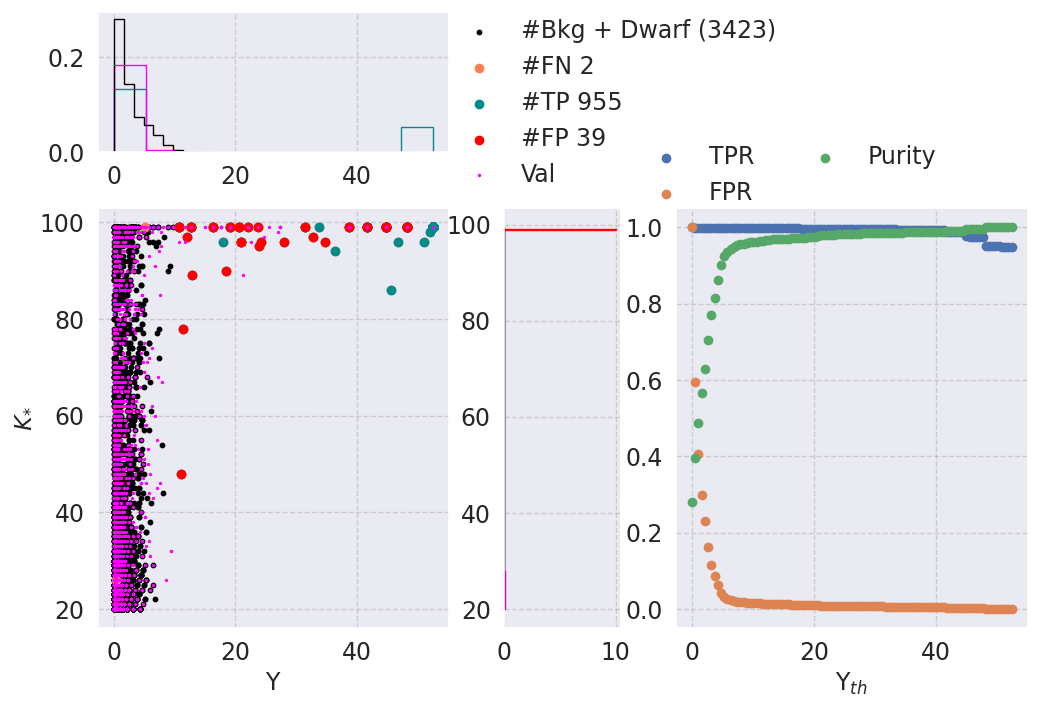

In [226]:
i = 38

upsilon = results[i]['stats']['Upsilon_i_plus']
kstar = results[i]['stats']['kstar_plus']
upsilon_na = result_dictionary_na['stats']['Upsilon_i_plus']
kstar_na = result_dictionary_na['stats']['kstar_plus']

try:
    ind = results[i]['unique_elements_overdensities'][list(results[i]['unique_elements_overdensities'].keys())[0]]
except:
    ind = np.where(upsilon > 10)[0]
#ind = results[i]['overdensities'][10]
bkg_ind = np.delete(np.arange(len(upsilon)), ind)

try:
    upsilon_val = results[i]['stats']['Upsilon_i_Val_plus']
    kstar_val = results[i]['stats']['kstar_Val_plus']
    validation = len(upsilon_val)
except:
    validation = None
TP = len(np.where(ind >= bkg[ipos])[0]) # True positives
FP = len(np.where(ind < bkg[ipos])[0]) # False positives
TN = len(np.where(bkg_ind < bkg[ipos])[0]) # True negative
FN = len(np.where(bkg_ind >= bkg[ipos])[0]) # False negative

up_range = np.linspace(np.min(upsilon), np.max(upsilon), nups)

statistic, p_value = ks_2samp(upsilon, upsilon_na)

fig,ax = plt.subplots(2,3, gridspec_kw = {'width_ratios':[3,1,3], 'height_ratios':[1,3]},
                     #sharex = 'col', sharey = 'row',
                      figsize = (12,8))

#plt.subplots_adjust()
ax[0,0].hist(upsilon, histtype = 'step', density = True, color = 'darkcyan')
if validation is not None: ax[0,0].hist(upsilon_val, histtype = 'step', density = True, color = 'magenta')
#ax[0,0].hist(upsilons[i][-len(dw_data):], histtype = 'step', density = True, color = 'red')
ax[0,0].hist(upsilon_na, histtype = 'step', density = True, color = 'black')

ax[0,1].set_axis_off()

ax[1,0].scatter(upsilon, kstar, label = f'#Bkg + Dwarf ({len(upsilon)})', color = 'black', s = 10)
ax[1,0].scatter(upsilon[-nstars[i]:], kstar[-nstars[i]:], label = f'#FN {FN}', color = 'coral')
ax[1,0].scatter(upsilon[ind], kstar[ind], color = 'darkcyan', #marker = 'o',s=52, facecolors='none', 
                label = f'#TP {len(np.where(ind >= bkg[i])[0])}')
ax[1,0].scatter(upsilon[ind[np.where(ind < bkg[i])[0]]], kstar[ind[np.where(ind < bkg[i])[0]]], color = 'red', 
                label = f'#FP {len(np.where(ind < bkg[i])[0])}')
if validation is not None: ax[1,0].scatter(upsilon_val, kstar_val, label = 'Val', color = 'magenta', s = 2)
ax[1,0].legend(loc = 'upper right', bbox_to_anchor = (1.99,1.5), frameon = False)
#ax[1,0].axvline(x = up_th)

ax[1,1].hist(kstar, histtype = 'step', density = True, color = 'darkcyan', orientation='horizontal')
if validation is not None: ax[1,1].hist(kstar_val, histtype = 'step', density = True, color = 'magenta', orientation='horizontal')
ax[1,1].hist(kstar[-len(dw_data):], histtype = 'step', density = True, color = 'red', orientation='horizontal')
ax[1,1].hist(kstar_na, histtype = 'step', density = True, color = 'black', orientation='horizontal')

ax[1,0].set_xlabel('$\\Upsilon$')
ax[1,0].set_ylabel('$K_{*}$')

#ax[1,0].text(0.45, 0.6,'Gal ID: {}'.format(Ids[i]), transform = ax[1,0].transAxes)
#ax[1,0].text(0.45, 0.5,'# Dwarf stars: {}'.format(nstars[i]), transform = ax[1,0].transAxes)
#ax[1,0].text(0.45, 0.4,'# Bkg stars: {} ({:.2f})'.format(bkg[i], nstars[i] / bkg[i]), transform = ax[1,0].transAxes)
#ax[1,0].text(0.45, 0.3,'(l,b) = ({:.0f}° ; {:.0f}°)'.format(glons[i], glats[i]), transform = ax[1,0].transAxes)
#ax[1,0].text(0.45, 0.2,'Pval = {:.1f}'.format(p_value), transform = ax[1,0].transAxes)

ax[0,2].set_axis_off()
ax[1,2].scatter(up_range, (1-aux_FNR[i,:]), label = 'TPR')
ax[1,2].scatter(up_range, aux_FPR[i,:], label = 'FPR')
ax[1,2].scatter(up_range, aux_pur[i,:], label = 'Purity')
ax[1,2].set_xlabel('$\\Upsilon_{th}$')
ax[1,2].legend(loc = 'upper right', bbox_to_anchor = (0.80,1.20), frameon = False, ncol = 2)

#plt.savefig(f'../graph/gal_{Ids[i]}_{bkg[i]}.pdf', bbox_inches='tight')


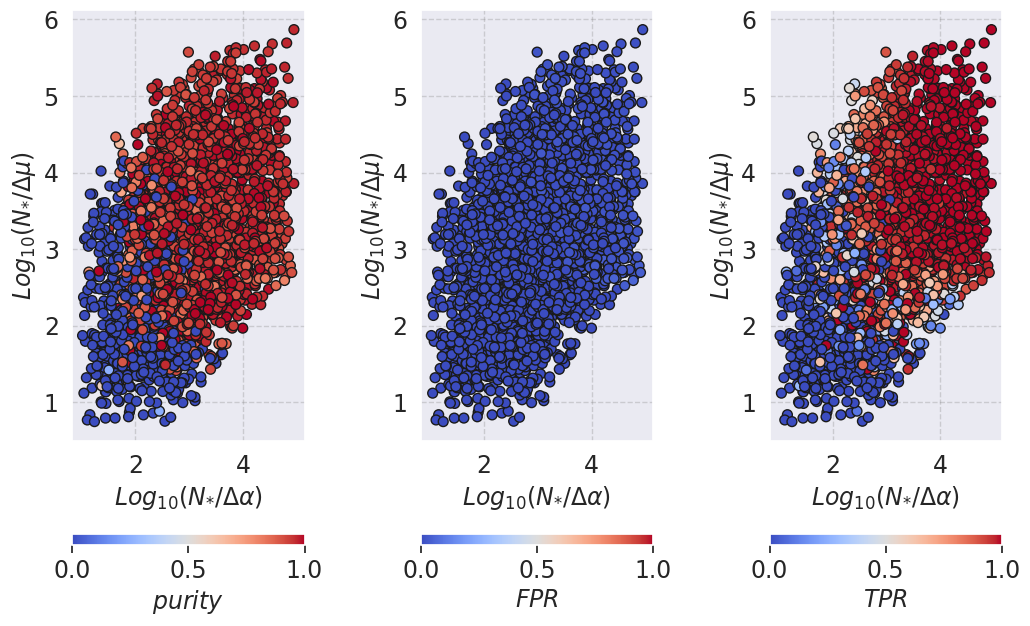

In [146]:
fig, ax = plt.subplots(1,3, figsize = (12,8))
plt.subplots_adjust(wspace = 0.5)

sc0 = ax[0].scatter(np.log10(np.asarray(nstars) / np.asarray(ang_sizes)), np.log10(np.asarray(nstars) / np.asarray(vpec_sizes)), c=stats[:,0], cmap='coolwarm', edgecolor='k', s=50,
                   vmin = 0, vmax = 1)
plt.colorbar(sc0, label='$purity$', orientation = 'horizontal')

ax[0].set_xlabel('$Log_{10}(N_{*}/\Delta \\alpha)$')
ax[0].set_ylabel('$Log_{10}(N_{*}/\Delta \mu)$')

sc1 = ax[1].scatter(np.log10(np.asarray(nstars) / np.asarray(ang_sizes)), np.log10(np.asarray(nstars) / np.asarray(vpec_sizes)), c=stats[:,1], cmap='coolwarm', edgecolor='k', s=50,
                   vmin = 0, vmax = 1)
plt.colorbar(sc1, label='$FPR$', orientation = 'horizontal')

ax[1].set_xlabel('$Log_{10}(N_{*}/\Delta \\alpha)$')
ax[1].set_ylabel('$Log_{10}(N_{*}/\Delta \mu)$')

sc2 = ax[2].scatter(np.log10(np.asarray(nstars) / np.asarray(ang_sizes)), np.log10(np.asarray(nstars) / np.asarray(vpec_sizes)), c=stats[:,2], cmap='coolwarm', edgecolor='k', s=50,
                   vmin = 0, vmax = 1)
plt.colorbar(sc2, label='$TPR$', orientation = 'horizontal')

ax[2].set_xlabel('$Log_{10}(N_{*}/\Delta \\alpha)$')
ax[2].set_ylabel('$Log_{10}(N_{*}/\Delta \mu)$')
#plt.yscale('log')
#plt.xscale('log')

plt.savefig(f'../graph/purity_{bkg[0]}_EEv7.pdf')

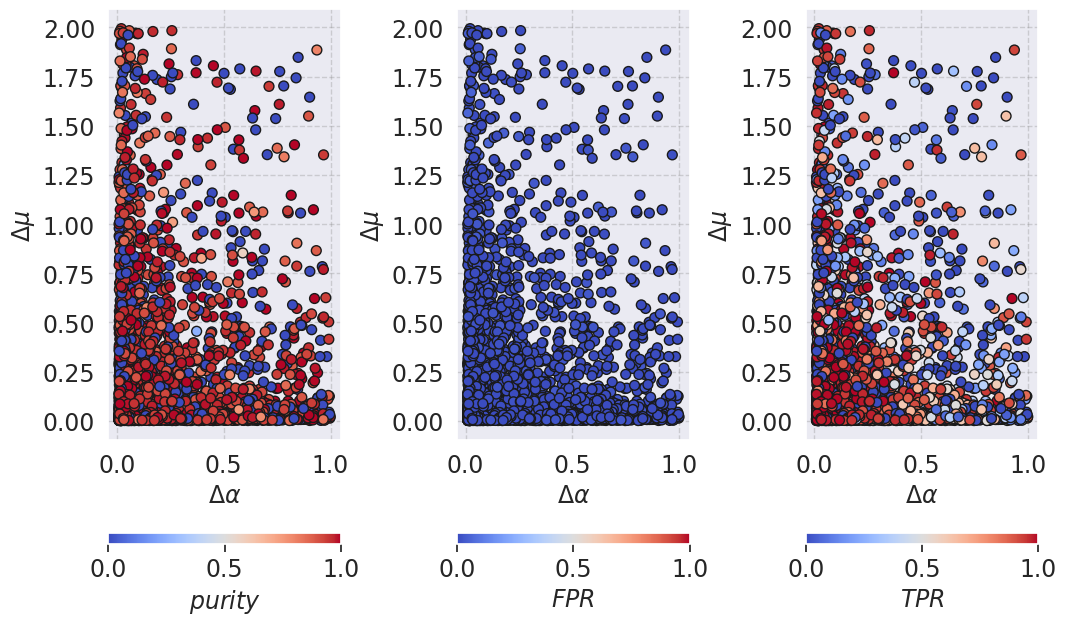

In [147]:
fig, ax = plt.subplots(1,3, figsize = (12,8))
plt.subplots_adjust(wspace = 0.5)

sc0 = ax[0].scatter((ang_sizes), (vpec_sizes), c=stats[:,0], cmap='coolwarm', edgecolor='k', s=50,
                   vmin = 0, vmax = 1)
plt.colorbar(sc0, label='$purity$', orientation = 'horizontal')

ax[0].set_xlabel('$\Delta \\alpha$')
ax[0].set_ylabel('$\Delta \mu$')

sc1 = ax[1].scatter((ang_sizes), (vpec_sizes), c=stats[:,1], cmap='coolwarm', edgecolor='k', s=50,
                   vmin = 0, vmax = 1)
plt.colorbar(sc1, label='$FPR$', orientation = 'horizontal')

ax[1].set_xlabel('$\Delta \\alpha$')
ax[1].set_ylabel('$\Delta \mu$')

sc2 = ax[2].scatter((ang_sizes), (vpec_sizes), c=stats[:,2], cmap='coolwarm', edgecolor='k', s=50,
                   vmin = 0, vmax = 1)
plt.colorbar(sc2, label='$TPR$', orientation = 'horizontal')

ax[2].set_xlabel('$\Delta \\alpha$')
ax[2].set_ylabel('$\Delta \mu$')
plt.savefig(f'../graph/purity2_{bkg[0]}_EEv7.pdf')


In [201]:
mean_pur, x_edges, y_edges, _ = binned_statistic_2d(np.log10(nstars / ang_sizes), np.log10(nstars / vpec_sizes), stats[:,0], statistic='mean', bins=20)
mean_FPR, _, _, _ = binned_statistic_2d(np.log10(nstars / ang_sizes), np.log10(nstars / vpec_sizes), stats[:,1], statistic='mean', bins=[x_edges,y_edges])
mean_TPR, _, _, _ = binned_statistic_2d(np.log10(nstars / ang_sizes), np.log10(nstars / vpec_sizes), stats[:,2], statistic='mean', bins=[x_edges,y_edges])

X_edges, Y_edges = np.meshgrid(x_edges, y_edges)

X_centers = 0.5 * (x_edges[:-1] + x_edges[1:])  # Centros de los bins en X
Y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])  # Centros de los bins en Y
X, Y = np.meshgrid(X_centers, Y_centers)

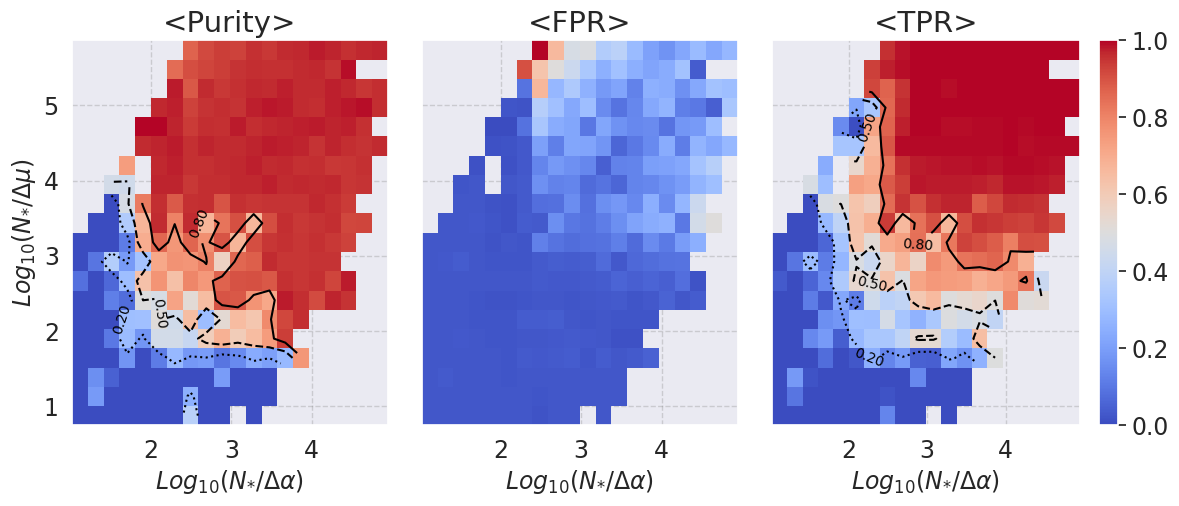

In [216]:
fig,ax = plt.subplots(1,3, figsize = (14,5), sharex = True, sharey = True, gridspec_kw = {'width_ratios':[0.82,0.82,1]})
plt.subplots_adjust(wspace = 0.1)

ax[0].pcolormesh(X_edges, Y_edges, mean_pur, cmap="coolwarm", shading='auto')
contours = ax[0].contour(X, Y, mean_pur, levels=[0.2, 0.5, 0.8], colors='black', linestyles = [':','--','solid'], origin='upper')
ax[0].clabel(contours, inline=True, fontsize=10, fmt="%.2f")
ax[0].set_xlabel('$Log_{10}(N_{*}/\Delta \\alpha)$')
ax[0].set_ylabel('$Log_{10}(N_{*}/\Delta \mu)$')
ax[0].set_title('<Purity>')

ax[1].pcolormesh(X_edges, Y_edges, mean_FPR, cmap="coolwarm", shading='auto')
contours = ax[1].contour(X, Y, mean_FPR, levels=[0.2, 0.5, 0.8], colors='black', linestyles = [':','--','solid'], origin='upper')
ax[1].clabel(contours, inline=True, fontsize=10, fmt="%.2f")
ax[1].set_xlabel('$Log_{10}(N_{*}/\Delta \\alpha)$')
ax[1].set_title('<FPR>')

cmap = ax[2].pcolormesh(X_edges, Y_edges, mean_TPR, cmap="coolwarm", shading='auto')
contours = ax[2].contour(X, Y, mean_TPR, levels=[0.2, 0.5, 0.8], colors='black', linestyles = [':','--','solid'], origin='upper')
ax[2].clabel(contours, inline=True, fontsize=10, fmt="%.2f")
ax[2].set_xlabel('$Log_{10}(N_{*}/\Delta \\alpha)$')
ax[2].set_title('<TPR>')
plt.colorbar(cmap, ax=ax[2])

plt.savefig(f'../graph/statsHeatmap_{bkg[0]}_EEv7.pdf')

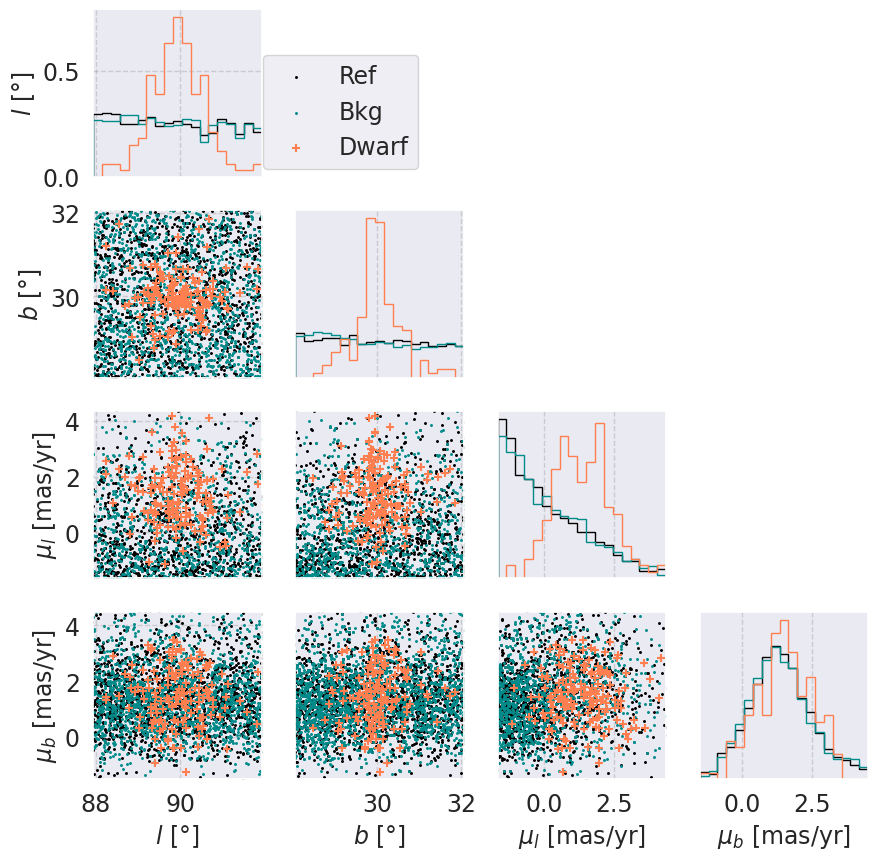

In [218]:
fig, ax  = plt.subplots(4,4, figsize = (10,10), sharex = 'col')

plt.subplots_adjust(hspace = 0.2, wspace = 0.2)

ax = plotDwarf(ax, dw_data, bkg_data, ref)

#plt.savefig('../graph/gal_{}_4d.pdf'.format(Id), bbox_inches='tight')

In [168]:
glat, glon = np.degrees(hp.pix2ang(nside, np.arange(NPIX)))
glat = 90 - glat

for ipur in range(nups):
#ipur = 0
    pur = aux_pur[:,ipur]
    mapa = np.zeros(NPIX)  # Array 1D de ejemplo
    mapa[np.where(np.abs(glat) > 20)[0]] = pur
    
    # Graficar el mapa en coordenadas Mollweide
    hp.mollview(mapa, title="", unit="Purity", cmap="viridis")
    
    plt.text(0, 1.1, "$\\Upsilon = ${:.2f}".format(up_range[ipur]), fontsize=12, color='black', ha='center')
    
    plt.savefig('../graph/960622/gif/Moolview_{}_pur.png'.format(ipur), bbox_inches='tight')
    plt.close()

In [251]:
aux_pur.shape

(16, 100)

Text(0, 1.1, '$\\Upsilon = $210.19')

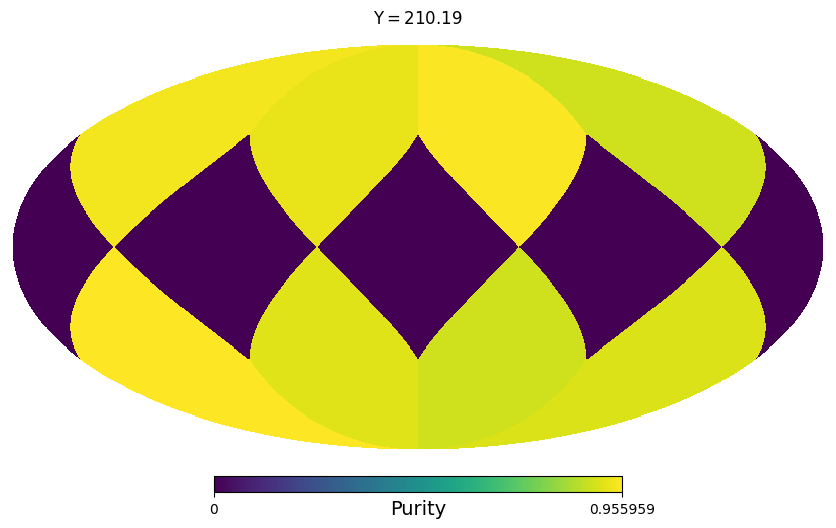

In [255]:
glat, glon = np.degrees(hp.pix2ang(nside, np.arange(NPIX)))
glat = 90 - glat

ipur = 60
pur = aux_pur[:8,ipur]
mapa = np.zeros(NPIX)  # Array 1D de ejemplo
mapa[np.where(np.abs(glat) > 20)[0]] = pur

# Graficar el mapa en coordenadas Mollweide
hp.mollview(mapa, title="", unit="Purity", cmap="viridis")

plt.text(0, 1.1, "$\\Upsilon = ${:.2f}".format(up_range[ipur]), fontsize=12, color='black', ha='center')